In [1]:
using Pkg
Pkg.activate("..")
Pkg.develop(["Equilibrium", "IMAS"])
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`
Path `/Users/meneghini/.julia/dev/Equilibrium` exists and looks like the correct package. Using existing path.
Path `/Users/meneghini/.julia/dev/IMAS` exists and looks like the correct package. Using existing path.
   Resolving package versions...
  No Changes to `~/.julia/dev/FUSE/Project.toml`
  No Changes to `~/.julia/dev/FUSE/Manifest.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [48]:
ϵ = 0.32
κ = 1.7
δ = 0.33
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 5.0

n=257

eq0 = FUSE.init(IMAS.equilibrium(), 0.0; B0, R0, ϵ, δ, κ, beta_n, ip)
eqactor = FUSE.SolovevEquilibriumActor(eq0, 0.0);
FUSE.step(eqactor)
eq1 = FUSE.finalize(eqactor,n);

eqt = eq1.time_slice[1]
println(eqt.global_quantities)

beta_normal ➡ 4.998352373837863
beta_pol ➡ 1.662116585293577
beta_tor ➡ 0.07132105862678166
energy_mhd ➡ Function
ip ➡ 1.5004048624566615e7
length_pol ➡ 17.173717138205312
magnetic_axis
｜r ➡ 6.599810481665925
｜z ➡ 0.0
q_95 ➡ Function
q_axis ➡ Function



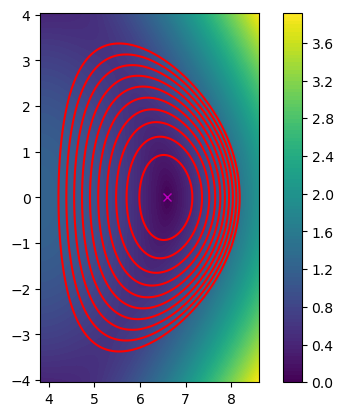

In [49]:
using PyPlot
Bp=sqrt.(eqt.profiles_2d[1].b_field_z.^2.0.+eqt.profiles_2d[1].b_field_r.^2.0)

PyPlot.figure()
CS=PyPlot.contour(eqt.profiles_2d[1].grid.dim1,
               eqt.profiles_2d[1].grid.dim2,
    transpose(eqt.profiles_2d[1].psi),levels=sort(range(eqt.profiles_1d.psi[1],eqt.profiles_1d.psi[end],length=11)),colors="r")
CS=PyPlot.contourf(eqt.profiles_2d[1].grid.dim1,
               eqt.profiles_2d[1].grid.dim2,
               transpose(Bp),levels=100)
#PyPlot.scatter(eqt.profiles_2d[1].grid.dim1'.*ones(n),ones(n)'.*eqt.profiles_2d[1].grid.dim2,marker=".",color="r")
PyPlot.plot(eqt.global_quantities.magnetic_axis.r,eqt.global_quantities.magnetic_axis.z,"mx")
PyPlot.gca().set_aspect("equal")
PyPlot.colorbar(CS);

  0.876037 seconds (4.71 M allocations: 342.543 MiB, 3.34% gc time)
513
  0.234552 seconds (1.56 M allocations: 107.879 MiB, 16.68% gc time)
257
  0.061463 seconds (646.37 k allocations: 38.846 MiB)
129
  0.028757 seconds (338.20 k allocations: 18.346 MiB)
65


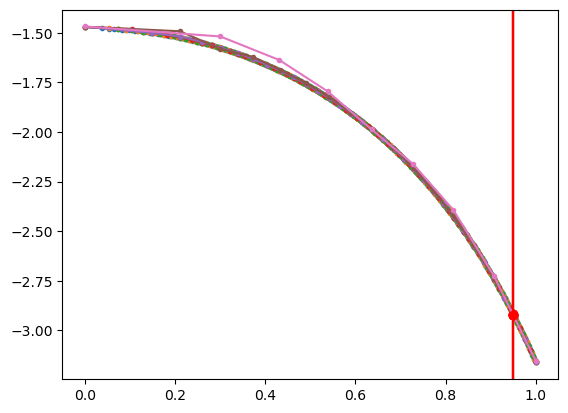

  0.018166 seconds (212.45 k allocations: 10.629 MiB)
33
  0.012251 seconds (145.48 k allocations: 7.000 MiB)
17
  0.008968 seconds (109.57 k allocations: 5.182 MiB)
9


In [50]:
PyPlot.figure()
for res in reverse(Vector{Int}(2.0.^collect(3:9).+1))
    try
    @time eq1=FUSE.finalize(eqactor,res)
    println(res)
    eqt = eq1.time_slice[1]
    PyPlot.plot(eqt.profiles_1d.rho_tor_norm,eqt.profiles_1d.q,".-")
        PyPlot.axvline(0.95,color="r")
        PyPlot.plot(0.95,eqt.global_quantities.q_95,"or")
    catch
        rethrow()
    end
end

In [55]:
function sensitivity_test(x)
    eq0=FUSE.init(IMAS.equilibrium(), 0.0; B0, R0, ϵ, δ, κ, beta_t=x, qstar)
    eqactor=FUSE.SolovevEquilibriumActor(eq0, 0.0);
    FUSE.step(eqactor; verbose=false)
    eqactor.S.beta_t
    #eq1=FUSE.finalize(eqactor,101);
    #eqt = eq1.time_slice[1]
    #eqt.global_quantities.beta_normal
end

bt0=sensitivity_test(0.05)

using ForwardDiff
dd = ForwardDiff.derivative(sensitivity_test,0.05)

println(dd)
bt1_predict=bt0+0.01*bt0/dd
bt1=sensitivity_test(0.06)

println(bt0)
println(bt1_predict)
println(bt1)

3.9153296316455286
0.0493817614948622
0.04950788564312225
0.05946288217066245


In [275]:
using ForwardDiff
fieldnames(ForwardDiff.Dual)

(:value, :partials)

In [286]:
using Interpolations
tmp=Interpolations.interpolate((eqt.profiles_2d[1].grid.dim1,eqt.profiles_2d[1].grid.dim2), eqt.profiles_2d[1].psi, Gridded(Linear()))
Interpolations.gradient(tmp, 2.0,0.0)

2-element StaticArrays.SVector{2, Float64} with indices SOneTo(2):
 -0.40540399085741985
  0.039713413151636345

In [199]:
using Equilibrium
psi=Equilibrium.psi_limits(eq.S)
psi=collect(range(psi[1],psi[end],length=100))
psin=collect(range(0.0,1.0,length=length(psi)))
p=Equilibrium.pressure(eq.S,psi)
pprime=Equilibrium.pressure_gradient(eq.S,psi)
f=Equilibrium.poloidal_current(eq.S,psi)
fprime=Equilibrium.poloidal_current_gradient(eq.S,psi)
mu0 = 4*pi*1e-7

function Psi(M::AbstractEquilibrium, dx=0.01,dy=0.01)
    xlims, ylims = limits(M)
    x = range(xlims...,step=dx)
    y = range(ylims...,step=dy)
    return collect(x),collect(y),[M(xx,yy) for xx in x, yy in y]
end

levels=sort(range(Equilibrium.psi_limits(eq.S)...,length=110))

x,y,PSI=Psi(eq.S)
PyPlot.contour(x,y,transpose(PSI),tmp)
PyPlot.gca().set_aspect("equal")
#PyPlot.plot(psin,f.*fprime)

LoadError: UndefVarError: tmp not defined

In [22]:
using Printf
digits = -Int(log10(1E-9))
txt = "α=%3.$(digits)f β_t=%3.$(digits)e precision=%3.$(digits)e\n"

@printf(txt, 1,2,3)

LoadError: LoadError: MethodError: no method matching Printf.Format(::Int64)
[0mClosest candidates are:
[0m  Printf.Format(::S, [91m::Vector{UnitRange{Int64}}[39m, [91m::T[39m) where {S, T} at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Printf/src/Printf.jl:64
[0m  Printf.Format([91m::AbstractString[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Printf/src/Printf.jl:80
in expression starting at In[22]:5